In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

# QuickBooks Read and Clean Data

In [2]:
#read csv for quickbooks
df = pd.read_csv("/Users/yashodhanjoglekar/Downloads/sales_copy.csv")

#Drop null fields 
df = df[pd.notnull(df['Date'])]
df = df[pd.notnull(df['jobcode_2'])]
df = df[df.Invoice >= 0]

#convert to date time
df['Date'] = pd.to_datetime(df['Date'], format= "%m/%d/%y %H:%M")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 4 columns):
Date         169 non-null datetime64[ns]
jobcode_2    169 non-null int64
jobcode_1    169 non-null object
Invoice      169 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.6+ KB


# TSheet Read and Clean Data

In [3]:
#read csv for timesheet
dfh = pd.read_csv("/Users/yashodhanjoglekar/Downloads/timesheet_report_2016-01-01_thru_2016-10-31.csv")

#Drop null fields 
dfh = dfh[pd.notnull(dfh['local_start_time'])]
dfh = dfh[pd.notnull(dfh['jobcode_2'])]

#Drop General Tasks
dfh = dfh[dfh.jobcode_2 != 9999]

#convert to date time
dfh['start_time'] = pd.to_datetime(dfh['local_start_time'], format="%m/%d/%y %H:%M")
dfh['end_time'] = pd.to_datetime(dfh['local_end_time'], format="%m/%d/%y %H:%M")

#Geetdata where hours logged are under 25
dfh1 = dfh[dfh['hours'] <= 25]

#If number of hours logged are greater than 25, Replace with mean of all data under 25 hours
dfh['hours'] = dfh['hours'].apply( lambda x: dfh1['hours'].mean() if x >= 25 else x)
dfh.describe()

,hours,jobcode_2
count,811.000000,811.000000
mean,1.823214,4333.022195
std,1.568462,62.997272
min,0.000000,4180.000000
25%,0.680000,4278.000000
50%,1.690000,4343.000000
75%,2.300000,4392.000000
max,13.580000,4419.000000


# Aggregate TSheet Data

In [4]:
#Get earliest start time , latest end time 
k = dfh.groupby(['jobcode_2','jobcode_1']).agg({'start_time': np.min, 'end_time' : np.max, 'hours':np.sum})

#Calculated field - Project Duration
k['project_duration'] = ((k.end_time - k.start_time).astype('timedelta64[m]'))/60

#Get Day of week
k['start_day'] = k['start_time'].apply( lambda x: x.dayofweek)
k['end_day'] = k['end_time'].apply( lambda x: x.dayofweek)

k = k.reset_index()
k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
jobcode_2           110 non-null int64
jobcode_1           110 non-null object
hours               110 non-null float64
end_time            110 non-null datetime64[ns]
start_time          110 non-null datetime64[ns]
project_duration    110 non-null float64
start_day           110 non-null int64
end_day             110 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 7.0+ KB


In [5]:
merged = df.merge(k, on='jobcode_2', how='left')
merged = merged.drop('jobcode_1_y', axis=1)

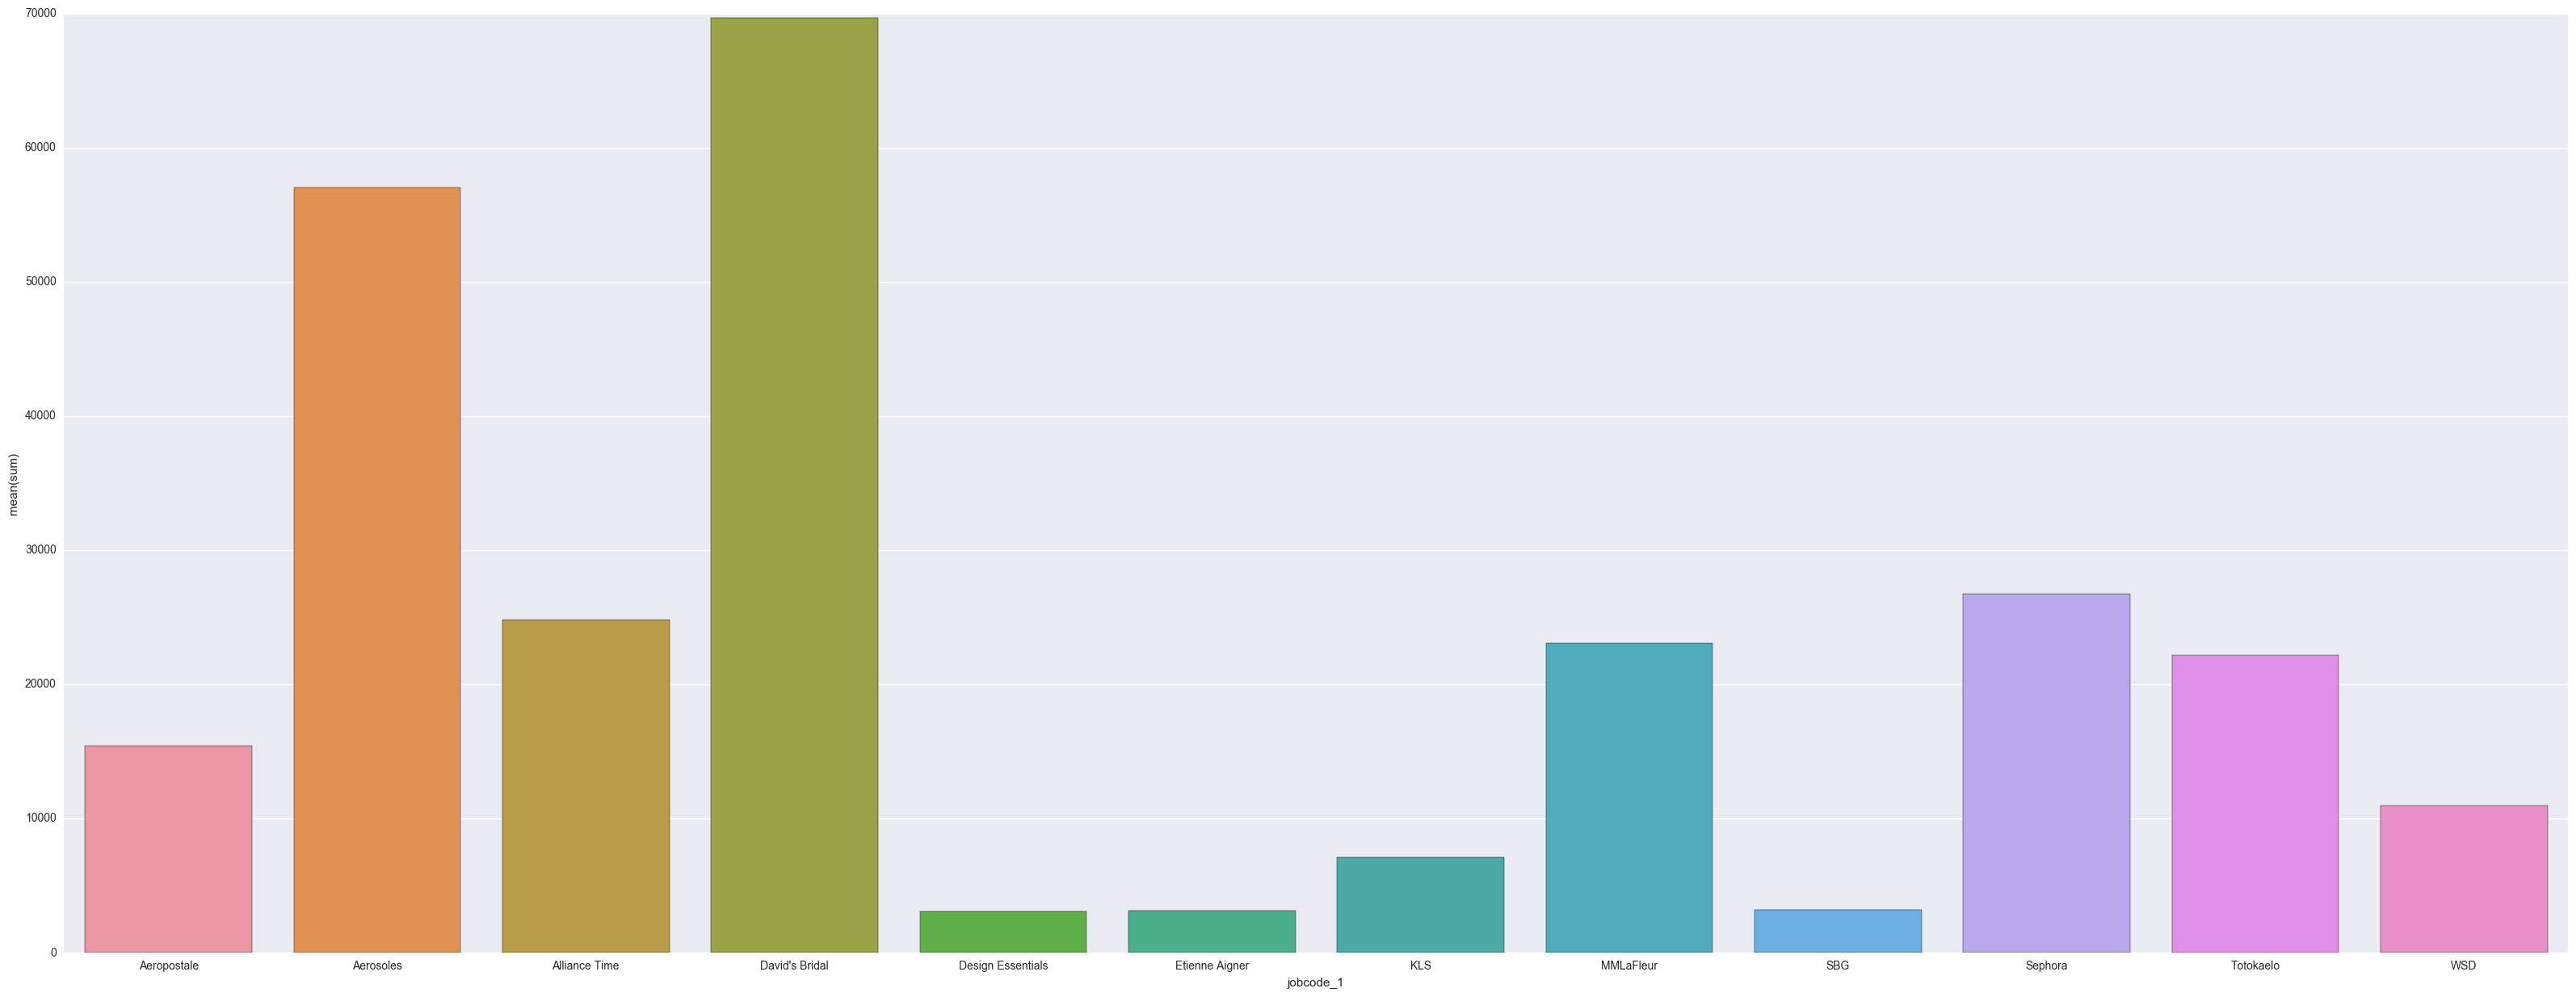

In [6]:
plt.figure(figsize=(40,15))
total_invoice_customer = df.groupby('jobcode_1')['Invoice'].agg({'sum'})
total_invoice_customer = total_invoice_customer.reset_index()
sns.barplot('jobcode_1', 'sum', data=total_invoice_customer);

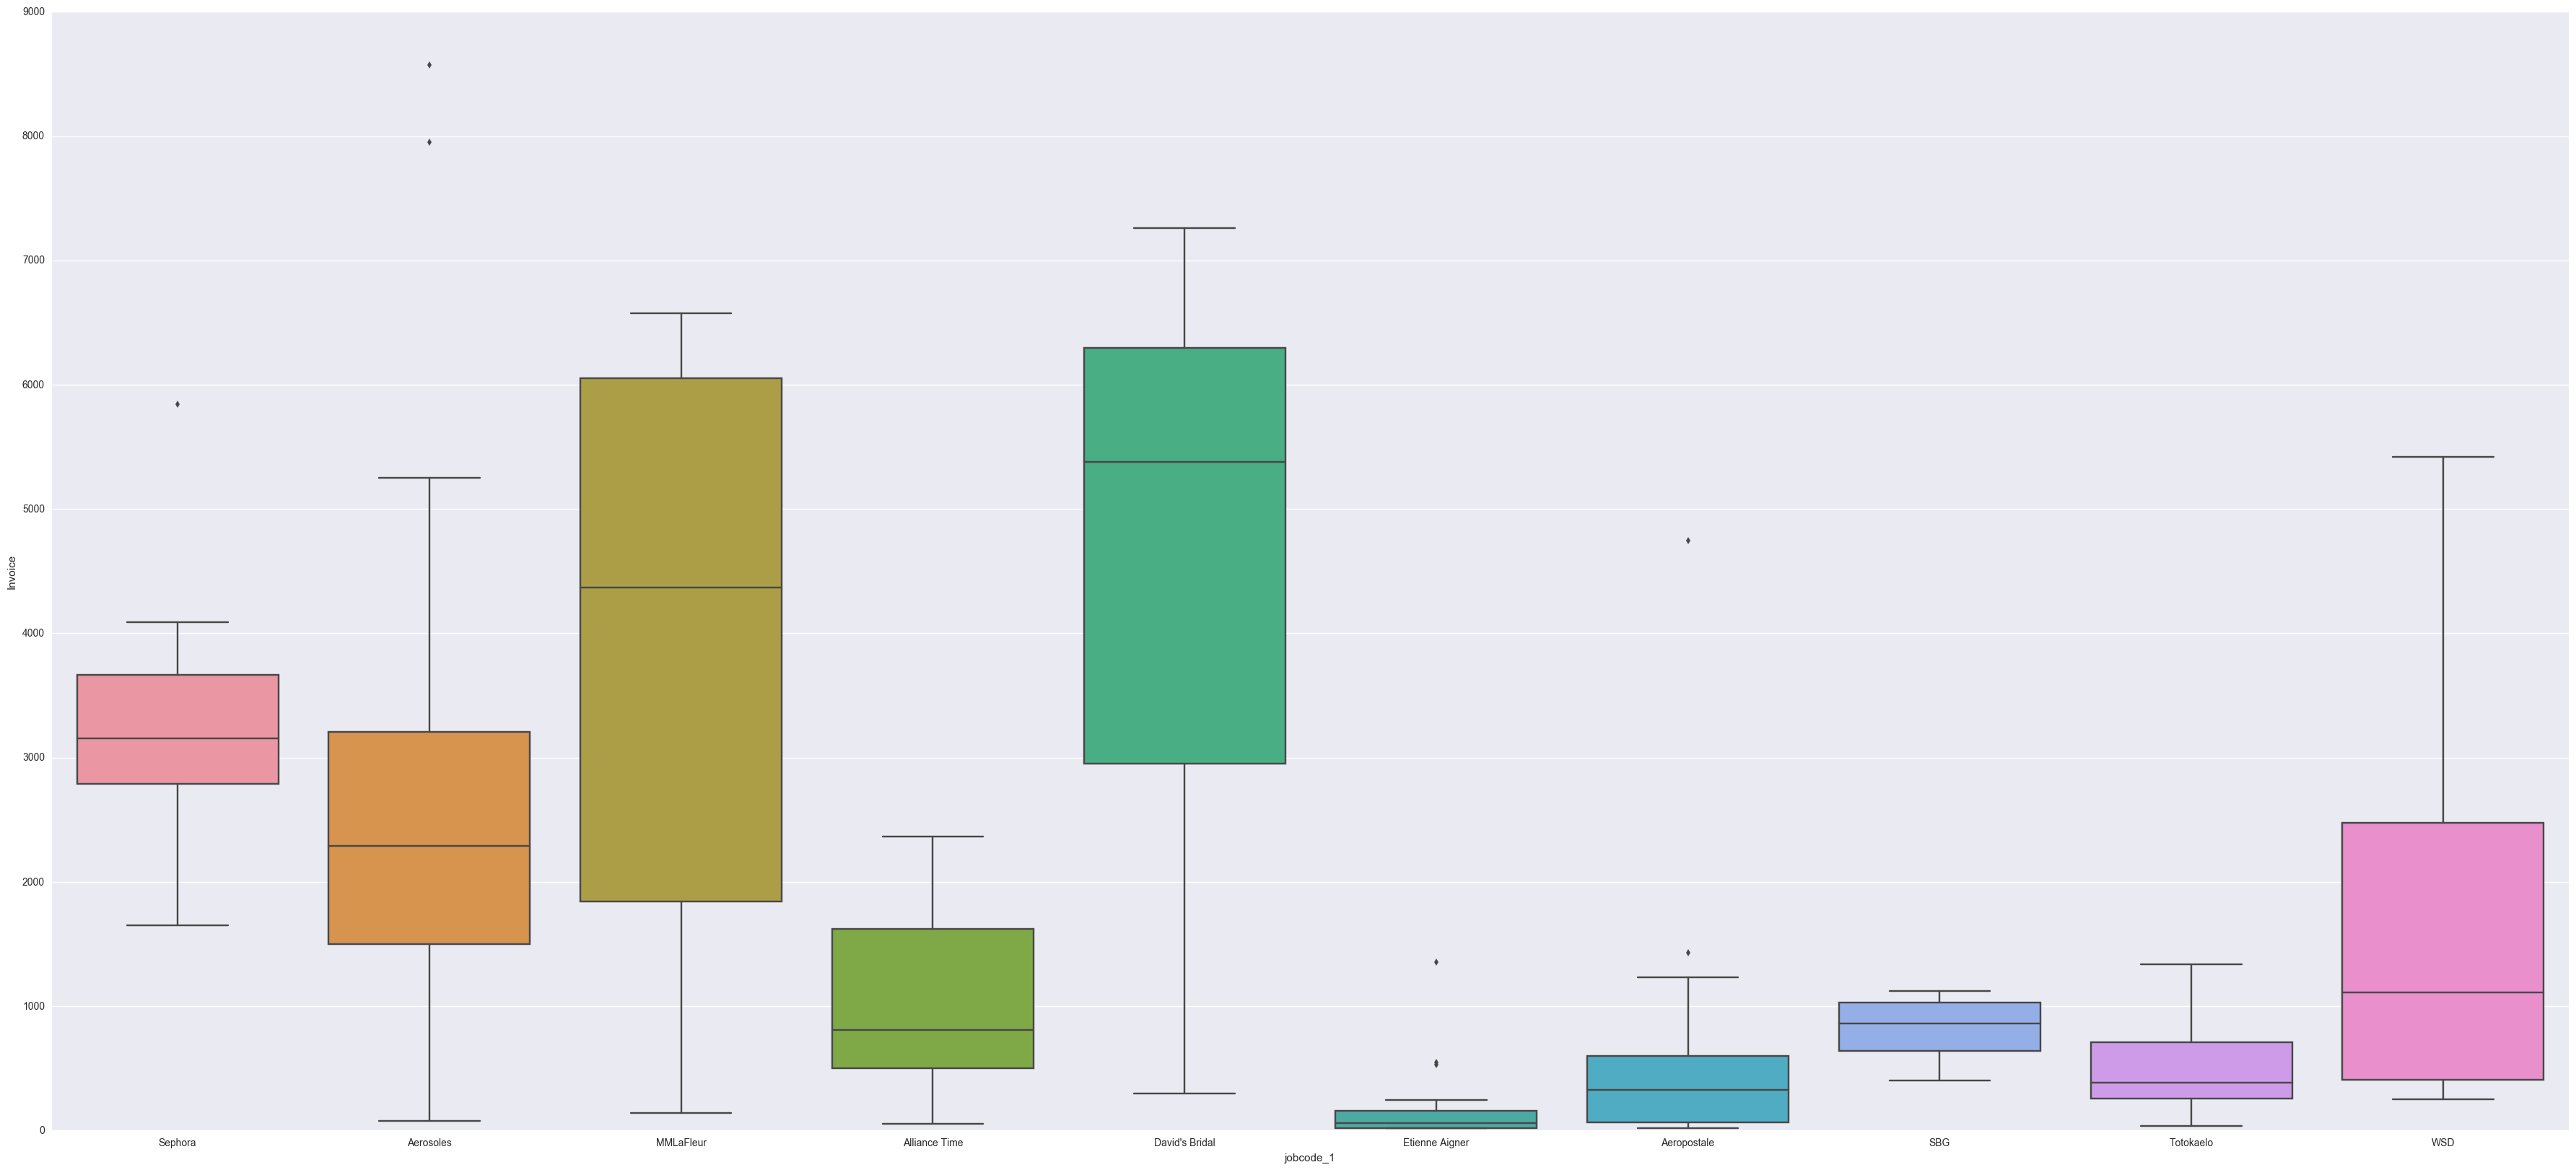

In [7]:

counta = df.groupby('jobcode_1').count()
df1 = df.loc[df['jobcode_1'].isin(counta[counta['jobcode_2'] > 3].index)]

#Eliminate outliers
df1 = df1[df1['Invoice'] <= df1['Invoice'].quantile(0.99)]

#Box plots for invoice amount
plt.figure(figsize=(45,20))
sns.boxplot('jobcode_1','Invoice', data=df1)

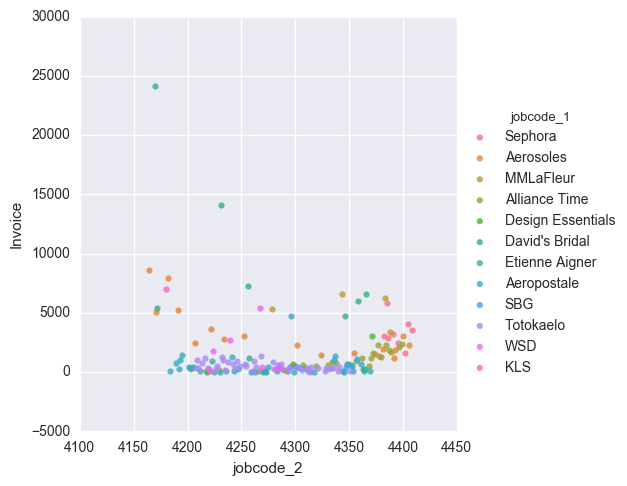

In [9]:
sns.lmplot('jobcode_2','Invoice',hue = 'jobcode_1', data=df, fit_reg = False)

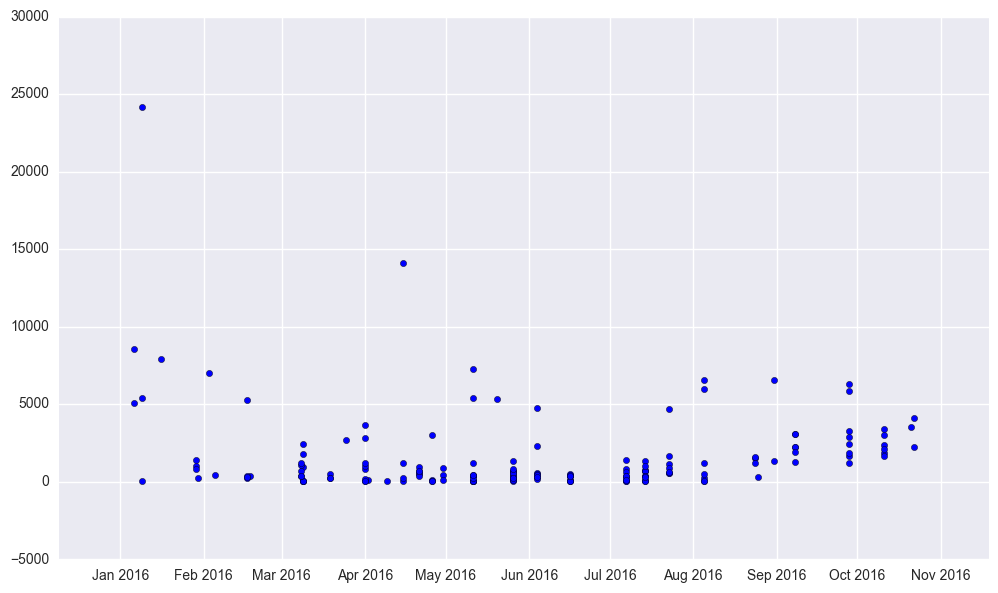

In [18]:
plt.figure(figsize=(12,7))
plt.scatter(df['Date'].values, df['Invoice'].values);

In [11]:
people_count = dfh.groupby("jobcode_2").agg({"hours": np.sum, "username": pd.Series.nunique})
people_count = people_count.reset_index()

,username,count
0,1,57
1,2,29
2,3,11
3,4,8
4,5,4
5,6,1


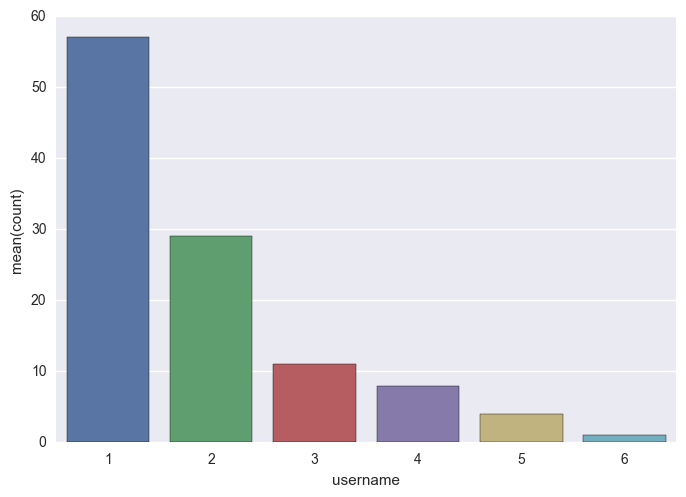

In [12]:
#Number of freelancers per project
people_count = people_count.groupby('username')['jobcode_2'].agg({'count'})
people_count = people_count.reset_index()
sns.barplot('username', 'count', data=people_count);
people_count

In [13]:
#Freelancer vs Inhouse
freelance = dfh.groupby(["group"]).agg({"hours": np.sum, "username": pd.Series.nunique})
#people_count = people_count.reset_index()
freelance= freelance.reset_index()
freelance

,group,hours,username
0,FREELANCERS,718.710000,10
1,FULL TIME,759.916428,5


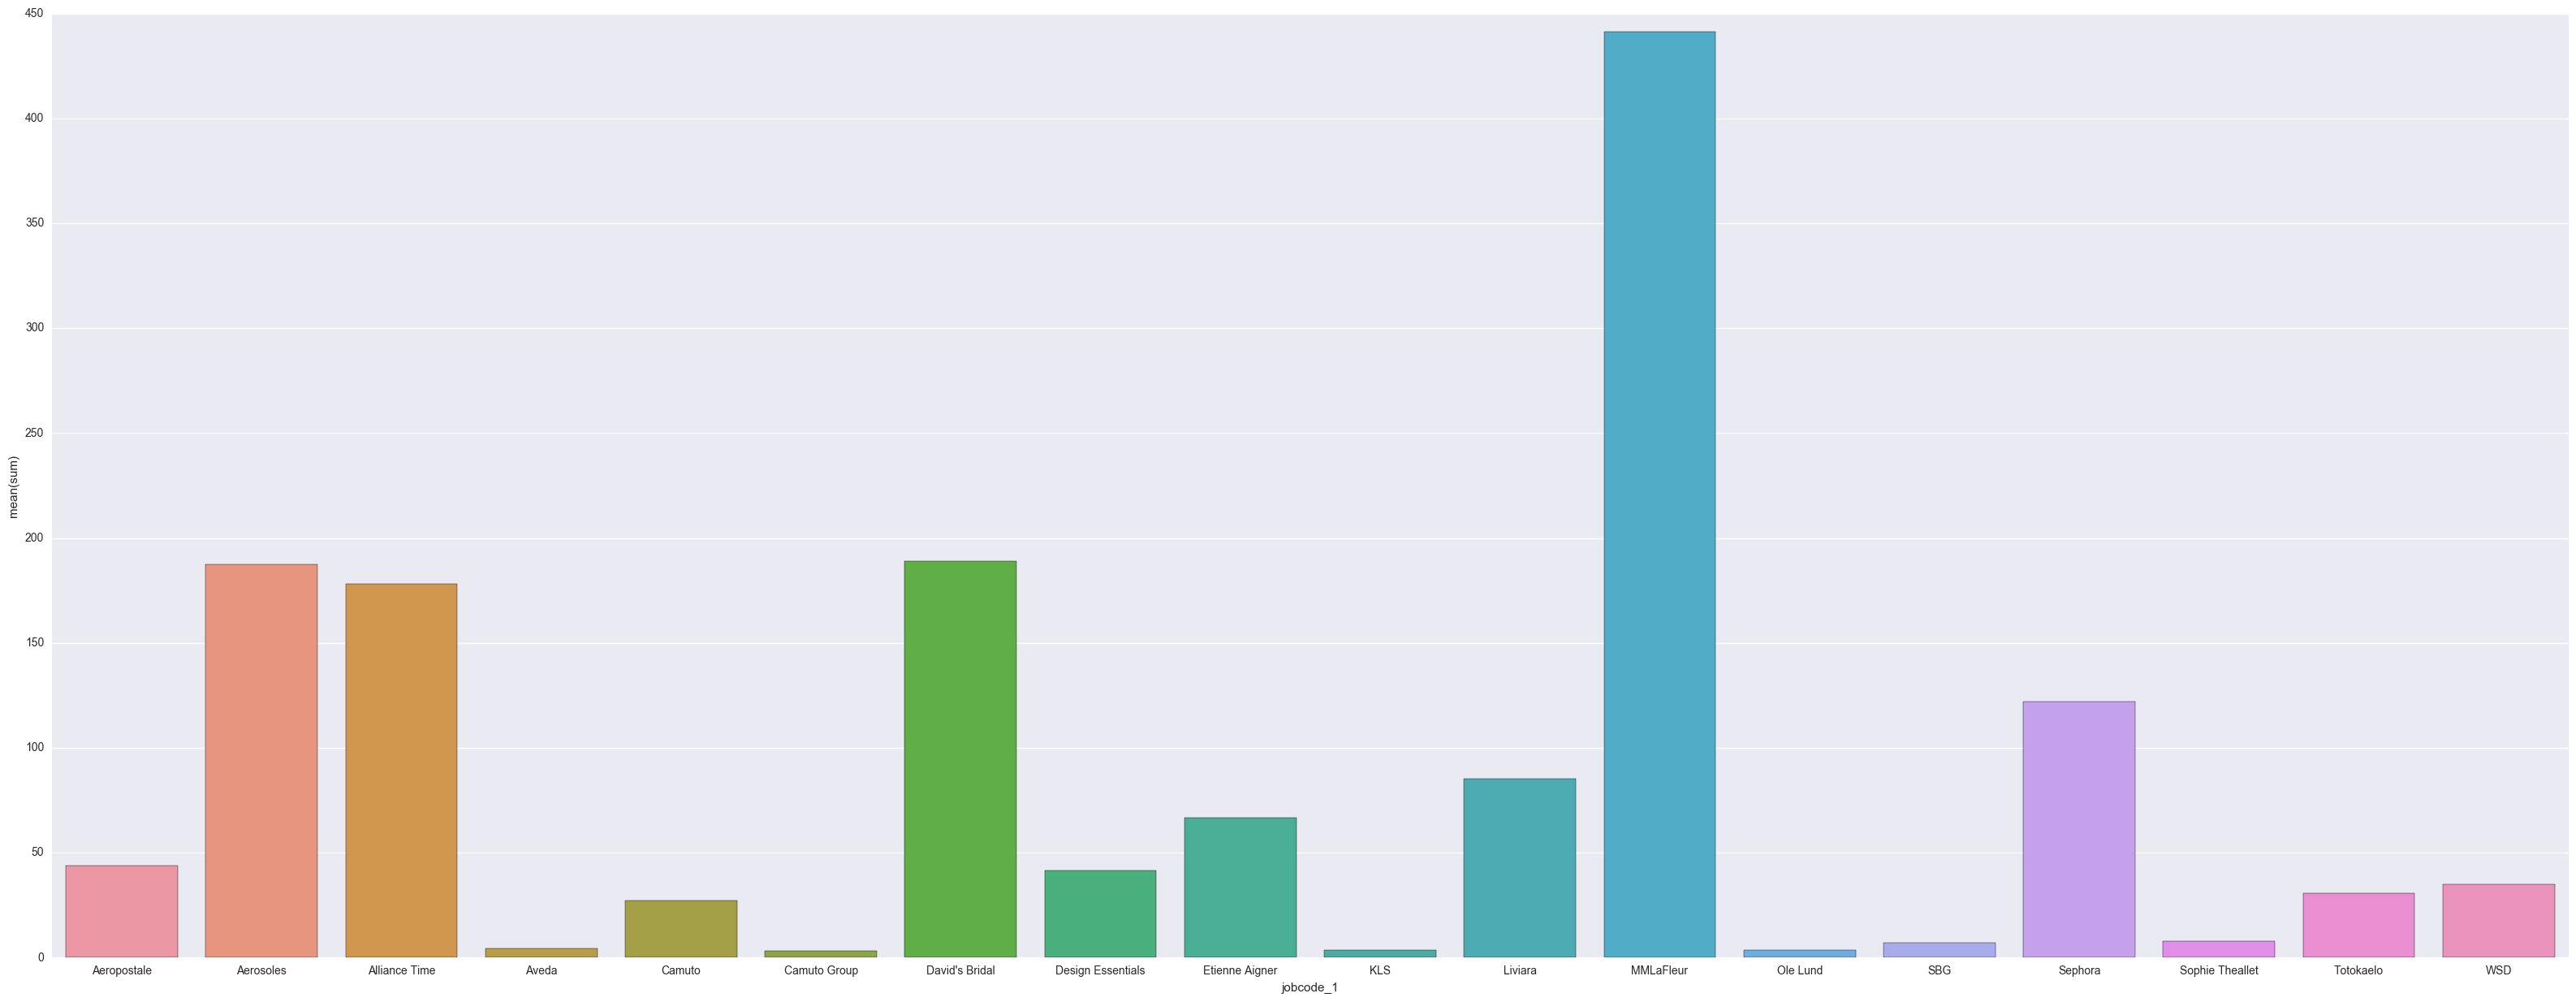

In [14]:
#Invoice value of jobs by customer
plt.figure(figsize=(40,15))
total_invoice_customer = dfh.groupby('jobcode_1')['hours'].agg({'sum'})
total_invoice_customer = total_invoice_customer.reset_index()
sns.barplot('jobcode_1', 'sum', data=total_invoice_customer);

In [14]:
df2 = df1.set_index('Date')
sales_state_avg = df2.groupby('jobcode_1').resample('M')['Invoice'].sum()
sales_state_avg = sales_state_avg.reset_index()
sales_state_avg


,jobcode_1,Date,Invoice
0,Aeropostale,2016-01-31,3590.0
1,Aeropostale,2016-02-29,1170.0
2,Aeropostale,2016-03-31,995.0
3,Aeropostale,2016-04-30,1600.0
4,Aeropostale,2016-05-31,1390.0
5,Aeropostale,2016-06-30,5200.0
6,Aeropostale,2016-07-31,1430.0
7,Aeropostale,2016-08-31,50.0
8,Aerosoles,2016-01-31,21625.0
9,Aerosoles,2016-02-29,5515.0


In [ ]:
groups = sales_state_avg.groupby('jobcode_1')

fig, ax = plt.subplots(figsize=(16,7))
for name, group in groups:
    ax.plot(group['Date'], group['Invoice'], marker='o', ms=3, label=name)
ax.legend(bbox_to_anchor=(1,1.2),ncol=4);

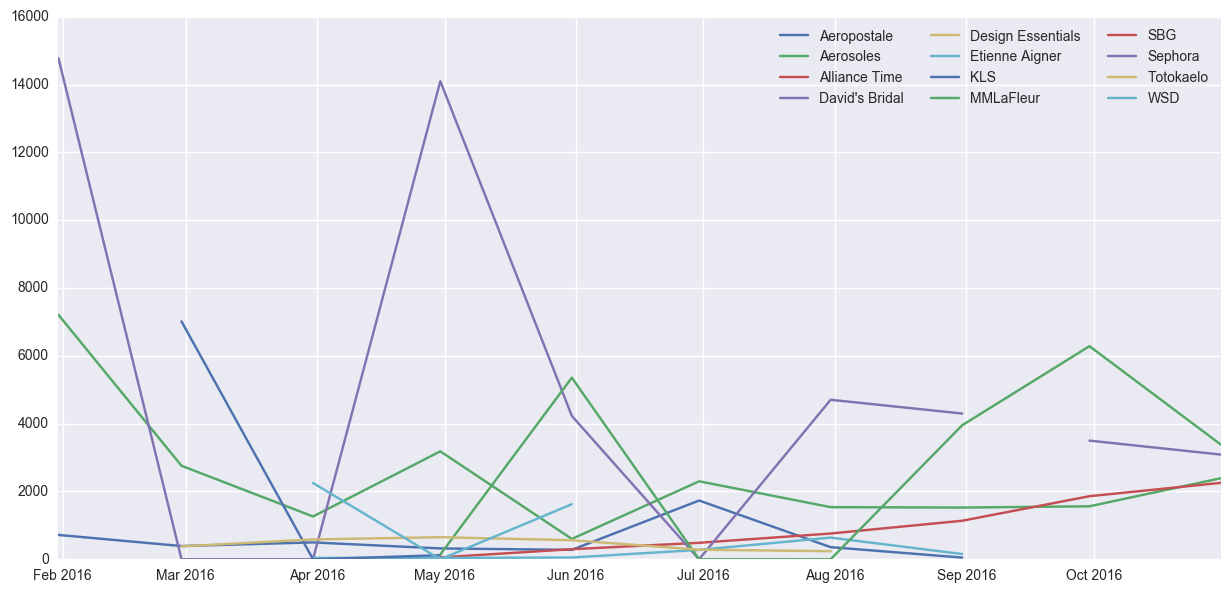

In [216]:
Invoice_avg = df2.groupby('jobcode_1').resample('M')['Invoice'].mean()
Invoice_avg = Invoice_avg.reset_index()
Invoice_avg['Invoice'].fillna(0, inplace=True)

groups = Invoice_avg.groupby('jobcode_1')

fig, ax = plt.subplots(figsize=(15,7))
for name, group in groups:
    ax.plot(group['Date'], group['Invoice'], marker='x', ms=1, label=name)
ax.legend(bbox_to_anchor=(1,1),ncol=3);

In [15]:
import plotly

In [16]:
plotly.tools.set_credentials_file(username='yashodhan19', api_key='fMxbekggO9Kb0Rta2NeU')

In [17]:
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~yashodhan19/0 or inside your plot.ly account where it is named 'basic-line'
